In [1]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from typing import List

from client.image_data_generator import ImageDataGenerator
from neural_network.layers.base_layer import BaseLayer
from neural_network.layers.linear_layer import LinearLayer
from neural_network.layers.relu_layer import ReluLayer
from neural_network.layers.sigmoid_layer import SigmoidLayer
from neural_network.models.layer_types import LayerTypes
from neural_network.utils import predict

from neural_network.losses.squared_loss import SquaredLoss

In [2]:
TRIAN_TF_MODEL = True

DATASET_PATH = "./images-data1/"
TEST_DATASET_PATH = "./images-data1-test/"
MASK_PATH = "./images-data1-mask/mask-6.mat"

EMBEDDING_FEATURE_DIM = 128

EPOCHS = 20
BATCH_SIZE = 2
LEARNING_RATE = 1e-3

In [3]:
train_data = ImageDataGenerator(
    dataset_path=DATASET_PATH, mask_path=MASK_PATH, use_dynamic_mask=True
)
test_data = ImageDataGenerator(
    dataset_path=TEST_DATASET_PATH, mask_path=MASK_PATH, use_dynamic_mask=True
)

2023-12-07 00:48:05.309058: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-07 00:48:05.309078: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-07 00:48:05.309081: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-07 00:48:05.309108: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-07 00:48:05.309121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
N_TRAIN = len(train_data)
N_TEST = len(test_data)

In [5]:
train_ds = (
    tf.data.Dataset.from_generator(
        train_data,
        output_types=(tf.float32, tf.float32),
        output_shapes=(
            tf.TensorShape([EMBEDDING_FEATURE_DIM]),
            tf.TensorShape([EMBEDDING_FEATURE_DIM]),
        ),
    )
    .shuffle(1000)
    .batch(BATCH_SIZE)
)


test_ds = tf.data.Dataset.from_generator(
    test_data,
    output_types=(tf.float32, tf.float32),
    output_shapes=(
        tf.TensorShape([EMBEDDING_FEATURE_DIM]),
        tf.TensorShape([EMBEDDING_FEATURE_DIM]),
    ),
).batch(1)

In [6]:
# min_val = np.inf
# max_val = -np.inf

# for x, y in train_ds:
#     miv = np.min(x)
#     mxv = np.max(x)

#     if miv < min_val:
#         min_val = miv
#     if mxv > max_val:
#         max_val = mxv

# print(min_val, max_val)

In [7]:
if TRIAN_TF_MODEL:
    tf_neural_net = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(EMBEDDING_FEATURE_DIM)),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(2, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(EMBEDDING_FEATURE_DIM),
        ]
    )

    tf_neural_net.compile(loss="mse", optimizer="adam", metrics="mse")

In [8]:
# neural network: nothing but a list of layers!
neural_net: List[BaseLayer] = [
    LinearLayer(input_size=EMBEDDING_FEATURE_DIM, output_size=10),
    ReluLayer(),
    LinearLayer(input_size=10, output_size=2),
    ReluLayer(),
    LinearLayer(input_size=2, output_size=10),
    ReluLayer(),
    LinearLayer(input_size=10, output_size=EMBEDDING_FEATURE_DIM),
    SigmoidLayer(),
]

loss = SquaredLoss()

In [9]:
if TRIAN_TF_MODEL:
    history = tf_neural_net.fit(train_ds, epochs=EPOCHS)

Epoch 1/20


2023-12-07 00:48:07.094479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 6s 9ms/step - loss: 0.1308 - mse: 0.1308
Epoch 2/20


2023-12-07 00:48:12.563363: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9125084997340737567
2023-12-07 00:48:12.563376: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1548386780986188335
2023-12-07 00:48:12.563408: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11196763579682936025
2023-12-07 00:48:12.563417: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13057540477022348369
2023-12-07 00:48:12.563429: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14262060631898334098
2023-12-07 00:48:12.563443: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11922394223534321636


82/82 [==============================] - 4s 7ms/step - loss: 0.0311 - mse: 0.0311
Epoch 3/20
82/82 [==============================] - 4s 7ms/step - loss: 0.0134 - mse: 0.0134
Epoch 4/20
82/82 [==============================] - 4s 7ms/step - loss: 0.0121 - mse: 0.0121
Epoch 5/20
82/82 [==============================] - 4s 7ms/step - loss: 0.0115 - mse: 0.0115
Epoch 6/20
82/82 [==============================] - 4s 7ms/step - loss: 0.0109 - mse: 0.0109
Epoch 7/20
82/82 [==============================] - 4s 7ms/step - loss: 0.0104 - mse: 0.0104
Epoch 8/20
82/82 [==============================] - 4s 7ms/step - loss: 0.0098 - mse: 0.0098
Epoch 9/20
82/82 [==============================] - 4s 7ms/step - loss: 0.0092 - mse: 0.0092
Epoch 10/20
82/82 [==============================] - 5s 7ms/step - loss: 0.0086 - mse: 0.0086
Epoch 11/20
82/82 [==============================] - 4s 7ms/step - loss: 0.0081 - mse: 0.0081
Epoch 12/20
82/82 [==============================] - 4s 7ms/step - loss: 0.0077

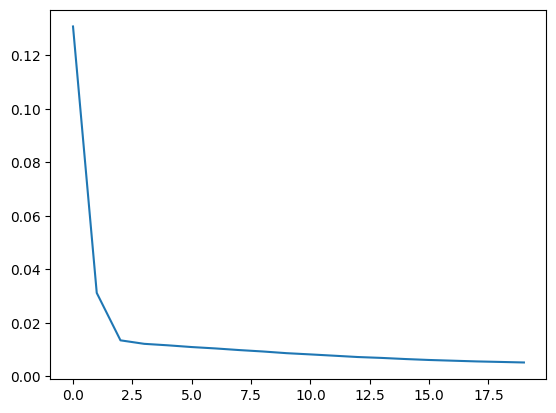

In [10]:
if TRIAN_TF_MODEL:
    plt.figure()
    plt.plot(history.history["loss"])

In [11]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = []
    for ix, (x_batch, y_batch) in enumerate(train_ds):
        X_batch: np.ndarray = np.array(x_batch)
        y_batch: np.ndarray = np.array(y_batch)

        # transpose, (m x N) and (n x N)
        X_batch = X_batch.T
        y_batch = y_batch.T

        ### forward propagation
        fps = []
        fp = X_batch
        for layer in neural_net:
            fp = layer.forward(fp, persist=True)
            fps.append(fp)

        train_loss = loss.forward(Yhat=fp, Y=y_batch)
        epoch_loss.append(train_loss)

        # final upstream grads
        # should ideally come from the loss function, assume it for now
        # (this will change when the loss function is implemented)
        # dLdY = np.random.randn(y_batch.shape[0], y_batch.shape[1])

        # compute the final upstream grads from the loss function
        dLdY = loss.backward(Yhat=fp, Y=y_batch)

        ### backprop
        # iterate the layers in reversed order for backprop, use chain rule recursively!
        for layer in reversed(neural_net):
            if layer.type == LayerTypes.ACTIVATION:
                dLdY = layer.backward(dLdY=dLdY)

            if layer.type == LayerTypes.LINEAR:
                # use these for gradient update
                dLdW, dLdb = layer.grads(dLdY=dLdY)

                ### gradient descent
                layer.weights -= LEARNING_RATE * dLdW
                layer.bias -= LEARNING_RATE * dLdb

                # new dLdY to pass to the previous layer
                dLdY = layer.backward(dLdY=dLdY)

    train_losses.append(np.mean(epoch_loss))
    # train_accuracies.append(accuracy(neural_net=neural_net, X_data=X_train, y_data=y_train))
    # test_accuracies.append(accuracy(neural_net=neural_net, X_data=X_test, y_data=y_test))

100%|██████████| 20/20 [01:16<00:00,  3.82s/it]


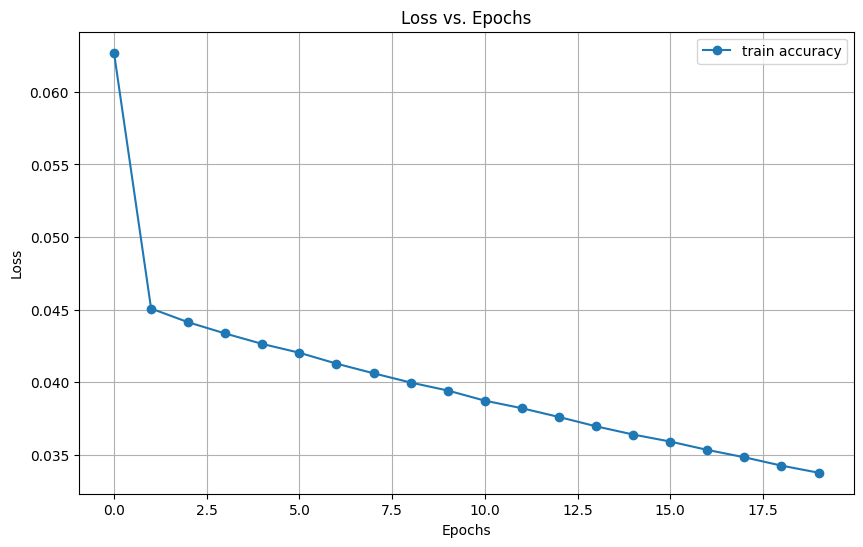

In [12]:
# plot the train and test accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(EPOCHS), train_losses, marker="o", linestyle="-", label="train accuracy")
# plt.plot(range(EPOCHS), test_accuracies, marker='s', linestyle='--', label='test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 14ms/step


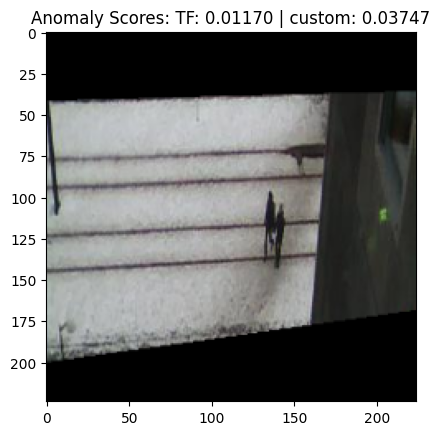

1/1 [==============================] - 0s 15ms/step


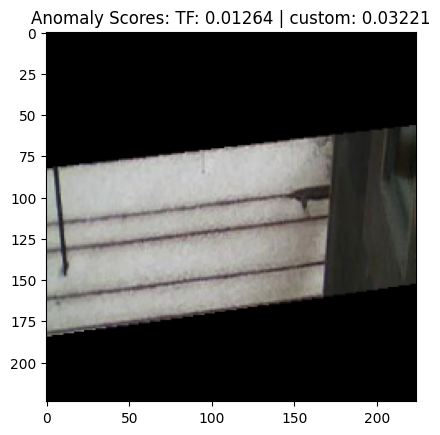

1/1 [==============================] - 0s 15ms/step


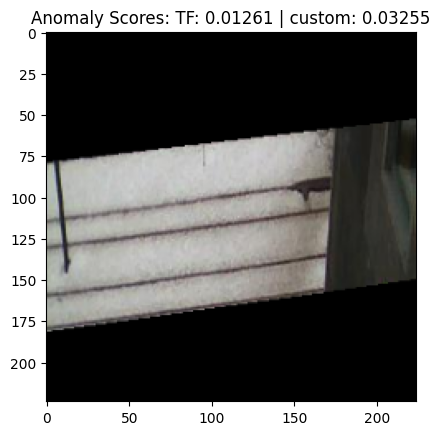

1/1 [==============================] - 0s 16ms/step


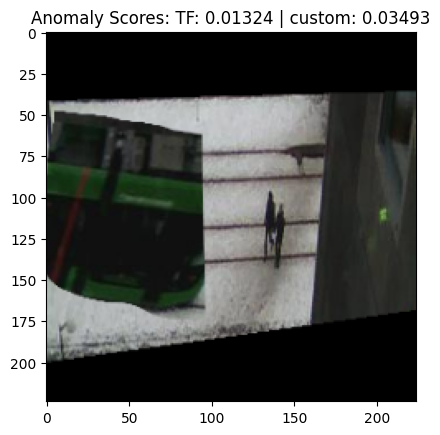

1/1 [==============================] - 0s 15ms/step


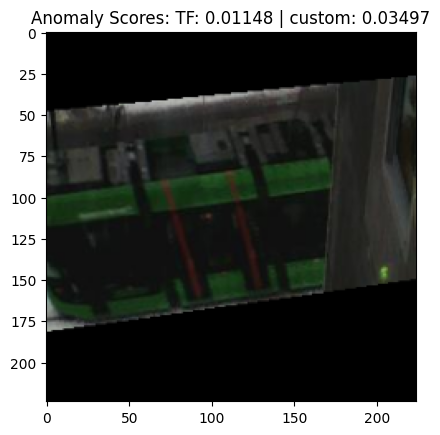

In [14]:
for ix, (x, y) in enumerate(test_ds):
    pred = predict(neural_net, np.array(x))

    score = np.mean(tf.square(y - pred))
    if TRIAN_TF_MODEL:
        tf_pred = tf_neural_net.predict(x)
        tf_score = tf.reduce_mean(tf.math.square(y - tf_pred))
    else:
        tf_score = 0.0

    plt.figure()
    plt.imshow(test_data.get_image(ix, apply_mask=True))
    plt.title(f"Anomaly Scores: TF: {tf_score:.5f} | custom: {score:.5f}")
    plt.show()